In [1]:
# This notebook is for stuff related to Mutual Information
import os
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn import preprocessing 

cwd = os.getcwd()
file = '/'.join(cwd.split('/')) + '/WA_Fn-UseC_-Sales-Win-Loss.csv'
data = pd.read_csv(file, index_col = 0)

In [2]:
# Data Preparition
data_clean = data.copy()
# Drop rows with opportunity amount 0
data_clean = data_clean.drop(data_clean[data_clean['Opportunity Amount USD'] == 0].index, axis = 0)
# Drop features that should not be used in training and prediction
data_clean = data_clean.drop(['Sales Stage Change Count', 'Elapsed Days In Sales Stage', 
                              'Ratio Days Identified To Total Days',
                              'Ratio Days Qualified To Total Days', 'Ratio Days Validated To Total Days', 
                              'Total Days Identified Through Closing', 'Total Days Identified Through Qualified',
                              'Deal Size Category'], 
                             axis = 1)
# Change opportunity result(our target variable) to numeric
minority = data_clean['Opportunity Result'].value_counts().idxmin()
result = np.array((data_clean['Opportunity Result'] == minority).astype(int))
data_clean = data_clean.drop(['Opportunity Result'], axis = 1)
# For each categorical variables in the dataset, try to assign an unique indicator variable 
#      for each different category
# (This may not be a good step because it adds too many columns, but we'll see)
for col in data_clean.columns:
    if is_string_dtype(data_clean[col]):
        name_set = set(data_clean[col])
        for name in name_set:
            data_clean[' '.join([col, name, 'indicator'])] = (data_clean[col] == name).astype(int)
        data_clean = data_clean.drop([col], axis = 1)
# Check if there is any null value in our dataset
if data_clean.isnull().any().any():
    print('NO!!!!!')
# Gladly, we don't have any

# Normalize our dataset
scale = preprocessing.StandardScaler()
data_clean = pd.DataFrame(scale.fit_transform(data_clean), columns = data_clean.columns)
data_clean['result'] = result

In [3]:
# Split data into training and test
length = len(data_clean['result'])
train_index = []
test_index = []
val_index = []
for i in range(length):
    rand = np.random.rand()
    if rand <= 0.8:
        train_index.append(i) 
    elif rand <= 0.9:
        val_index.append(i)
    else:
        test_index.append(i)

In [4]:
# Mutual information
from sklearn.feature_selection import mutual_info_classif as mic
mi_list = mic(data_clean.drop('result', axis = 1).values, data_clean['result'].values)
mi_list = list(mi_list)
mi_dict = dict(zip(data_clean.columns[0: -1], mi_list))

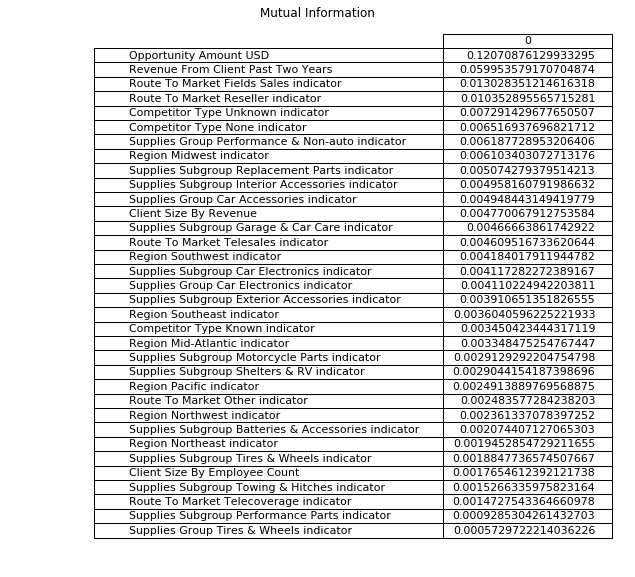

In [6]:
from pandas.plotting import table
import matplotlib.pyplot as plt
%matplotlib inline
mi_df = pd.DataFrame.from_dict(mi_dict, orient = 'index').sort_values(by = 0, ascending = False)

fig, ax = plt.subplots(figsize=(11, 10)) # set size frame 
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, mi_df, loc='upper right', colWidths=[0.23]*len(mi_df.columns))
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(11) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table
plt.title('Mutual Information')
#plt.savefig('table.png', transparent=True)
plt.show()

In [8]:
mi_to_rm = set(data_clean.columns) - set(mi_df.iloc[:4].index) - set(['result'])
data_mi = data_clean.drop(mi_to_rm, axis = 1)
mi_train = data_mi.iloc[train_index, :]
mi_test = data_mi.iloc[val_index, :]
final_test = data_mi.iloc[test_index, :]

In [14]:
# Create a parameter grid to sample from during fitting
rf = RandomForestClassifier(random_state=42)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', "log2", None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               "criterion": criterion}

In [15]:
# Use the random grid to search for best hyperparameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
start = time.time()

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 10, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(mi_train.drop("result", 1), mi_train['result'])

end = time.time()
print('Time taken in random grid: {0: .2f}'.format(end - start))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=80, criterion=entropy, bootstrap=False 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=80, criterion=entropy, bootstrap=False 
[CV] n_estimators=600, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=80, criterion=entropy, bootstrap=False 
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True, total=   9.9s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=30, criterion=gini, bootstrap=True, tota

[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=1, max_features=log2, max_depth=80, criterion=gini, bootstrap=False, total=  35.5s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.7min finished


Time taken in random grid:  474.83


In [16]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': 30,
 'criterion': 'entropy',
 'bootstrap': True}

In [18]:
# Train a first model with these parameters
from sklearn.metrics import roc_curve, auc, roc_auc_score
rf_1 = rf_random.best_estimator_
rf_1.fit(mi_train.drop("result", 1), mi_train['result'])
# Make prediction
rf_1_pred = rf_1.predict_proba(mi_test.drop("result", 1))
# Get AUC
roc_auc_score(mi_test["result"], rf_1_pred[:,1])

0.8361187945084246

In [19]:
from sklearn.model_selection import GridSearchCV
gs_mi = RandomForestClassifier()
param_dist = {'max_depth': [20, 30, 40, 50],
              'max_features': [2, 3, None],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [80, 100, 200, 400]}

cv_rf = GridSearchCV(gs_mi, cv = 3,
                     param_grid=param_dist,
                     n_jobs = 3, verbose = 10)

cv_rf.fit(mi_train.drop(['result'], axis = 1), mi_train['result'])

print('Best Parameters using grid search: \n',
      cv_rf.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8062907367173613, total=   7.4s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8201975308641976, total=   7.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    8.6s


[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8167407407407408, total=   7.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, score=0.8063894923958128, total=   7.6s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, score=0.8211851851851852, total=   7.7s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, score=0.8149135802469136, total=   8.0s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estima

[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   34.9s


[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, score=0.82, total=  15.4s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, score=0.8160493827160494, total=  16.0s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.8068338929488446, total=  30.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.82, total=  31.3s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.816, tota

[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.2min


[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8055006912897492, total=   6.4s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8224197530864198, total=   6.4s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8166913580246914, total=   6.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, score=0.8045131345052341, total=   7.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n

[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  1.8min


[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, score=0.8202469135802469, total=  21.7s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200, score=0.816395061728395, total=  21.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, score=0.806142603199684, total=  34.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=400, score=0.8205925925925925, total=  36.4s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  2.8min


[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=80, score=0.8164938271604938, total=   6.7s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, score=0.8066363815919415, total=   7.7s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, score=0.8217283950617283, total=   7.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, score=0.8168888888888889, total=   7.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12,

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  3.8min


[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8056488248074264, total=   5.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.8171358024691358, total=  33.7s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.819604938271605, total=   6.2s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.816641975308642, total=   6.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  4.4min


[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, score=0.816641975308642, total=  16.3s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400, score=0.8058463361643294, total=  33.0s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=400, score=0.8198024691358025, total=  33.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=80, score=0.8053031799328462, total=   5.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estima

[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:  5.6min


[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=0.8209382716049383, total=  15.3s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=0.8176296296296296, total=  15.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=0.8050069128974916, total=  29.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=0.8204444444444444, total=  29.9s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, 

[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  6.6min


[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8047600237013628, total=  14.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8224197530864198, total=  15.1s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8173827160493827, total=  15.3s
[CV] max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.8060932253604582, total=  29.0s
[CV] max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=4, min_samples_split=12, 

[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:  7.9min


[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, score=0.8208888888888889, total=  15.7s
[CV] max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, score=0.8165432098765432, total=  17.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400, score=0.8039699782737507, total=  30.5s
[CV] max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400, score=0.8215308641975309, total=  30.8s
[CV] max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, n_esti

[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:  9.1min


[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8169876543209876, total=  15.6s
[CV] max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.8030317993284614, total=  28.7s
[CV] max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.8208888888888889, total=  29.0s
[CV] max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=80, score=0.8034761998814932, total=   6.0s
[CV] max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=12, n_

[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed: 10.8min


[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8065870037527157, total=   6.4s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8220740740740741, total=   6.6s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400, score=0.8170864197530864, total=  32.6s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8168395061728395, total=   6.8s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimato

[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed: 12.2min


[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8170864197530864, total=   6.8s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, score=0.8057969583251037, total=   7.8s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, score=0.8230617283950618, total=   8.1s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, score=0.8176296296296296, total=   8.4s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=10,

[Parallel(n_jobs=3)]: Done 139 tasks      | elapsed: 13.8min


[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, score=0.8228148148148148, total=  16.2s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, score=0.8179753086419753, total=  17.7s
[CV] max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.807969583251037, total=  33.5s
[CV] max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.822962962962963, total=  33.9s
[CV] max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=8, n_est

[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed: 15.8min


[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=80, score=0.8224197530864198, total=   6.6s
[CV] max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400, score=0.8175308641975308, total=  34.6s
[CV] max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=80, score=0.8177283950617283, total=   7.0s
[CV] max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, score=0.8066363815919415, total=   8.0s
[CV] max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n

[Parallel(n_jobs=3)]: Done 175 tasks      | elapsed: 17.5min


[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8223703703703704, total=  16.4s
[CV] max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8181728395061728, total=  17.3s
[CV] max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.8058463361643294, total=  31.4s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.8219753086419753, total=  32.2s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=8, n_e

[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed: 19.5min


[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=80, score=0.8174320987654321, total=   6.8s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, score=0.8049081572190401, total=   8.0s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, score=0.821925925925926, total=   8.2s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, score=0.818320987654321, total=   8.5s
[CV] max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=10, n

[Parallel(n_jobs=3)]: Done 215 tasks      | elapsed: 21.8min


[CV]  max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8083152281256172, total=   7.1s
[CV] max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, score=0.8175308641975308, total=  33.5s
[CV] max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8240493827160493, total=   7.3s
[CV] max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8188641975308641, total=   7.9s
[CV] max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=20, max_features=None, min_samples_leaf=3, min_sam

[Parallel(n_jobs=3)]: Done 236 tasks      | elapsed: 23.8min


[CV]  max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200, score=0.8183703703703704, total=  18.5s
[CV] max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=400, score=0.8089077621963263, total=  34.6s
[CV] max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=400, score=0.824, total=  35.4s
[CV] max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=80, score=0.8086608730001975, total=   7.4s
[CV] max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=None, min_samples_leaf=3, min_sample

[Parallel(n_jobs=3)]: Done 259 tasks      | elapsed: 26.5min


[CV]  max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=200, score=0.8243456790123457, total=  17.3s
[CV] max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=200, score=0.8184691358024692, total=  18.7s
[CV] max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400, score=0.8072289156626506, total=  34.7s
[CV] max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400, score=0.8234074074074074, total=  35.6s
[CV] max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, max_features=None, min_samples_leaf=4, m

[Parallel(n_jobs=3)]: Done 282 tasks      | elapsed: 29.0min


[CV]  max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.809154651392455, total=  16.5s
[CV] max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8239506172839506, total=  17.3s
[CV] max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8194074074074074, total=  18.5s
[CV] max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.8084139838040687, total=  34.2s
[CV] max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=20, max_features=None, min_samples_leaf

[Parallel(n_jobs=3)]: Done 307 tasks      | elapsed: 31.7min


[CV]  max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8239506172839506, total=  17.0s
[CV] max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8187654320987654, total=  17.7s
[CV] max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.8060932253604582, total=  34.0s
[CV] max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.8234074074074074, total=  35.1s
[CV] max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=20, max_features=None, min_samples_lea

[Parallel(n_jobs=3)]: Done 332 tasks      | elapsed: 34.3min


[CV]  max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, score=0.8152098765432099, total=  16.1s
[CV] max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.8047600237013628, total=  31.3s
[CV] max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.82, total=  32.3s
[CV] max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8059944696820067, total=   6.3s
[CV] max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=80, sco

[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 37.3min


[CV]  max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8056488248074264, total=   6.0s
[CV] max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8184197530864198, total=   6.2s
[CV] max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=30, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.8167407407407408, total=  32.8s
[CV] max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8154567901234568, total=   6.4s
[CV] max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimato

[Parallel(n_jobs=3)]: Done 386 tasks      | elapsed: 39.8min


[CV]  max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=80, score=0.8169876543209876, total=   6.2s
[CV] max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, score=0.8056982026466522, total=   7.3s
[CV] max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, score=0.8211358024691358, total=   7.5s
[CV] max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=100, score=0.8169876543209876, total=   8.0s
[CV] max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  max_depth=30, max_features=2, min_samples_leaf=4, min_samples_split=12,

[Parallel(n_jobs=3)]: Done 415 tasks      | elapsed: 42.5min


[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8209876543209876, total=  15.2s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8161481481481482, total=  16.0s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.8033280663638159, total=  29.7s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.8205925925925925, total=  30.4s
[CV] max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=30, max_features=2, min_samples_leaf=5, min_samples_split=12, 

[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed: 45.6min


[CV]  max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8203456790123457, total=   6.5s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.8162962962962963, total=  35.5s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8157037037037037, total=   7.0s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100, score=0.8055994469682006, total=   8.0s
[CV] max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  max_depth=30, max_features=3, min_samples_leaf=3, min_samples_split=10, n

[Parallel(n_jobs=3)]: Done 475 tasks      | elapsed: 48.6min


[CV]  max_depth=30, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, score=0.8224197530864198, total=  16.2s
[CV] max_depth=30, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  max_depth=30, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, score=0.8169382716049383, total=  17.2s
[CV] max_depth=30, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  max_depth=30, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400, score=0.8063894923958128, total=  31.4s
[CV] max_depth=30, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  max_depth=30, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=400, score=0.8216296296296296, total=  32.6s
[CV] max_depth=30, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  max_depth=30, max_features=3, min_samples_leaf=4, min_samples_split=10, n_esti

[Parallel(n_jobs=3)]: Done 506 tasks      | elapsed: 51.9min


[CV]  max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=80, score=0.8173333333333334, total=   6.8s
[CV] max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, score=0.8054513134505235, total=   7.9s
[CV] max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, score=0.8226666666666667, total=   8.0s
[CV] max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, score=0.816641975308642, total=   8.5s
[CV] max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimat

[Parallel(n_jobs=3)]: Done 539 tasks      | elapsed: 55.5min


[CV]  max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8082164724471657, total=   6.6s
[CV] max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV]  max_depth=30, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, score=0.8173827160493827, total=  34.4s
[CV] max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8240987654320988, total=   7.1s
[CV] max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8174814814814815, total=   8.0s
[CV] max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=30, max_features=None, min_samples_leaf=3, min_sam

[Parallel(n_jobs=3)]: Done 572 tasks      | elapsed: 58.9min


[CV]  max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=200, score=0.8188148148148148, total=  19.1s
[CV] max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.8093521627493581, total=  34.6s
[CV] max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.8240493827160493, total=  35.7s
[CV] max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8074264270195536, total=   6.9s
[CV] max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=30, max_features=None, min_samples_leaf=4, m

[Parallel(n_jobs=3)]: Done 607 tasks      | elapsed: 62.9min


[CV]  max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.823604938271605, total=  17.7s
[CV] max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8177283950617283, total=  18.5s
[CV] max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.8083646059648429, total=  34.9s
[CV] max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.823604938271605, total=  35.8s
[CV] max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=30, max_features=None, min_samples_leaf=5,

[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 67.1min


[CV]  max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=200, score=0.8063894923958128, total=  16.8s
[CV] max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=200, score=0.824, total=  17.3s
[CV] max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=200, score=0.8184197530864198, total=  17.9s
[CV] max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=30, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=400, score=0.8064388702350385, total=  33.5s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV]  max_depth=30, max_features=None, min_samples_leaf=5, min_samples

[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, score=0.804710645862137, total=  17.7s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400 


[Parallel(n_jobs=3)]: Done 679 tasks      | elapsed: 71.0min


[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, score=0.8196543209876543, total=  18.8s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, score=0.8167901234567901, total=  20.7s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.8054513134505235, total=  34.6s
[CV] max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.8193086419753086, total=  33.9s
[CV] max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=8, n_e

[CV]  max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8203456790123457, total=  18.9s
[CV] max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 


[Parallel(n_jobs=3)]: Done 716 tasks      | elapsed: 108.0min


[CV]  max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.817037037037037, total=  17.1s
[CV] max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.8061919810389098, total=  32.1s
[CV] max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=40, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.8209382716049383, total=  33.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=80, score=0.8044637566660083, total=   6.4s
[CV] max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estima

[CV]  max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, score=0.8159506172839506, total=  16.5s
[CV] max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400, score=0.8048587793798143, total=  30.1s
[CV] max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV]  max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400, score=0.8209876543209876, total=  31.2s
[CV] max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80 


[Parallel(n_jobs=3)]: Done 755 tasks      | elapsed: 112.3min


[CV]  max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.80653762591349, total=   7.5s
[CV] max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV]  max_depth=40, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=400, score=0.8163456790123457, total=  33.9s
[CV] max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8205432098765432, total=   7.1s
[CV] max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=80, score=0.8156543209876543, total=   7.6s
[CV] max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators

[CV]  max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8064882480742642, total=   6.3s
[CV] max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=40, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.817283950617284, total=  36.9s
[CV] max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8203456790123457, total=   6.6s
[CV] max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed: 116.8min


[CV]  max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8159506172839506, total=   7.1s
[CV] max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, score=0.8061919810389098, total=   8.2s
[CV] max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, score=0.821925925925926, total=   8.4s
[CV] max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, score=0.8171851851851852, total=   8.7s
[CV] max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  max_depth=40, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimat

[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=80, score=0.8160493827160494, total=   6.8s
[CV] max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, score=0.8053031799328462, total=   7.6s
[CV] max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, score=0.8216296296296296, total=   8.0s
[CV] max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, score=0.817037037037037, total=   8.7s
[CV] max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimat

[Parallel(n_jobs=3)]: Done 835 tasks      | elapsed: 120.9min


[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, score=0.8220246913580247, total=  16.3s
[CV] max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200, score=0.8171358024691358, total=  17.2s
[CV] max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, score=0.8042662453091053, total=  33.8s
[CV] max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=80 
[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=400, score=0.8220246913580247, total=  34.6s
[CV] max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=80 
[CV]  max_depth=40, max_features=3, min_samples_leaf=5, min_samples_split=10, n_esti

[CV] max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200, score=0.8249876543209876, total=  17.9s
[CV] max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200, score=0.8173333333333334, total=  19.1s
[CV] max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.808759628678649, total=  36.5s
[CV] max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.8241481481481482, total=  38.1s
[CV] max_depth=40, max_features=None, min_samples_leaf=3, min

[Parallel(n_jobs=3)]: Done 876 tasks      | elapsed: 125.6min


[CV]  max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8240493827160493, total=   7.3s
[CV] max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.8177777777777778, total=  39.9s
[CV] max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8189135802469136, total=   7.6s
[CV] max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=100, score=0.8080189610902627, total=   8.7s
[CV] max_depth=40, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  max_depth=40, max_features=None, min_samples_leaf

[CV]  max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=80, score=0.8076733162156824, total=   9.8s
[CV] max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400, score=0.8175802469135802, total=  48.1s
[CV]  max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=80, score=0.823604938271605, total=   8.5s
[CV] max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV] max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=80, score=0.8188641975308641, total=   7.4s
[CV] max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  max_depth=40, max_features=None, min_samples_leaf=4,

[Parallel(n_jobs=3)]: Done 919 tasks      | elapsed: 130.6min


[CV]  max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=0.8245432098765432, total=  18.2s
[CV] max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=0.8177283950617283, total=  18.9s
[CV] max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=0.8080189610902627, total=  34.2s
[CV] max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=80 
[CV]  max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=0.8236543209876543, total=  35.5s
[CV] max_depth=40, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=80 
[CV]  max_depth=40, max_features=None, min_samples_lea

[CV]  max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8061919810389098, total=  17.8s
[CV] max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8237037037037037, total=  18.3s
[CV] max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8178271604938272, total=  18.5s
[CV] max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.8062907367173613, total=  -1.7s
[CV] max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=40, max_features=None, min_samples_le

[Parallel(n_jobs=3)]: Done 962 tasks      | elapsed: 134.9min


[CV]  max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=80, score=0.8190123456790124, total=   7.2s
[CV] max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=100, score=0.8057969583251037, total=   8.4s
[CV] max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=100, score=0.8225679012345679, total=   8.8s
[CV] max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=100, score=0.8180740740740741, total=   9.1s
[CV] max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  max_depth=40, max_features=None, min_samples_le

[CV] max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=80, score=0.8162469135802469, total=   6.5s
[CV] max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, score=0.8056982026466522, total=   7.8s
[CV] max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, score=0.8205925925925925, total=   7.9s
[CV] max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=100, score=0.816641975308642, total=   8.3s
[CV] max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n

[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 139.9min


[CV]  max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8028342879715583, total=   6.2s
[CV] max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80 
[CV]  max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8199012345679012, total=   6.3s
[CV] max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=400, score=0.8161481481481482, total=  33.2s
[CV] max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=80, score=0.8159506172839506, total=   6.8s
[CV] max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimato

[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=80, score=0.8035749555599447, total=   6.4s
[CV] max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=80, score=0.820395061728395, total=   6.4s
[CV] max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  max_depth=50, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.8167407407407408, total=  33.2s
[CV] max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=80, score=0.8161481481481482, total=   7.0s
[CV] max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimator

[Parallel(n_jobs=3)]: Done 1052 tasks      | elapsed: 144.7min


[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200, score=0.8159506172839506, total=  16.3s
[CV] max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400 
[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400, score=0.8031305550069129, total=  30.5s
[CV] max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=80 
[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=400, score=0.8214814814814815, total=  31.3s
[CV] max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=80 
[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=80, score=0.8034268220422675, total=   6.1s
[CV] max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=80 
[CV]  max_depth=50, max_features=2, min_samples_leaf=5, min_samples_split=10, n_esti

[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, score=0.8162962962962963, total=  23.7s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.8055994469682006, total=  37.6s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.8215308641975309, total=  38.0s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=80, score=0.8074264270195536, total=   6.4s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_esti

[Parallel(n_jobs=3)]: Done 1099 tasks      | elapsed: 149.8min


[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, score=0.8209382716049383, total=  16.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=200, score=0.8167901234567901, total=  16.9s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400, score=0.8070807821449734, total=  35.8s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=80 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=400, score=0.821925925925926, total=  36.9s
[CV] max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=80 
[CV]  max_depth=50, max_features=3, min_samples_leaf=3, min_samples_split=12, n

[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=0.8222222222222222, total=  16.6s
[CV] max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=0.8160493827160494, total=  18.9s
[CV] max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=0.8071795378234249, total=  38.4s
[CV] max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=80 
[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=0.8216296296296296, total=  41.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=80 
[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, 

[Parallel(n_jobs=3)]: Done 1146 tasks      | elapsed: 154.8min


[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8061919810389098, total=  15.9s
[CV] max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8218271604938272, total=  16.2s
[CV] max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, score=0.8173333333333334, total=  17.0s
[CV] max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=400, score=0.8056982026466522, total=  32.7s
[CV] max_depth=50, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=80 
[CV]  max_depth=50, max_features=3, min_samples_leaf=4, min_samples_split=12, 

[CV]  max_depth=50, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, score=0.8050069128974916, total=  18.0s
[CV] max_depth=50, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, score=0.8217777777777778, total=  18.6s
[CV] max_depth=50, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, score=0.8173333333333334, total=  17.5s
[CV] max_depth=50, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400 
[CV]  max_depth=50, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=400, score=0.8049081572190401, total=  30.7s
[CV] max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=80 
[CV]  max_depth=50, max_features=3, min_samples_leaf=5, min_samples_split=1

[Parallel(n_jobs=3)]: Done 1195 tasks      | elapsed: 161.0min


[CV]  max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200, score=0.822962962962963, total=  26.0s
[CV] max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=200, score=0.8166913580246914, total=  26.8s
[CV] max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400 
[CV]  max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.8089571400355521, total=  41.7s
[CV] max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=8, n_estimators=400, score=0.8241481481481482, total=  42.2s
[CV] max_depth=50, max_features=None, min_samples_leaf=3, min_samples_split=10, n_estimators=80 
[CV]  max_depth=50, max_features=None, min_samples_leaf=3, mi

[CV]  max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=200, score=0.8082658502863914, total=  28.4s
[CV] max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=200, score=0.8220246913580247, total=  28.8s
[CV] max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=200, score=0.8173333333333334, total=  25.8s
[CV] max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400 
[CV]  max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=8, n_estimators=400, score=0.8073276713411021, total=  37.3s
[CV] max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=80 
[CV]  max_depth=50, max_features=None, min_samples_leaf=4, m

[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed: 167.1min


[CV]  max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, score=0.8178765432098766, total=  21.9s
[CV] max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400 
[CV]  max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=0.8080189610902627, total=  36.4s
[CV] max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=80 
[CV]  max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400, score=0.823358024691358, total=  37.1s
[CV] max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=80 
[CV]  max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=80, score=0.8086114951609717, total=   7.8s
[CV] max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=12, n_estimators=80 
[CV]  max_depth=50, max_features=None, min_samples_leaf=4

[CV]  max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8239012345679012, total=  17.4s
[CV] max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=200, score=0.8184197530864198, total=  18.4s
[CV] max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400 
[CV]  max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.8073276713411021, total=  38.2s
[CV] max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=10, n_estimators=400, score=0.8241975308641976, total=  39.5s
[CV] max_depth=50, max_features=None, min_samples_leaf=5, min_samples_split=12, n_estimators=80 
[CV]  max_depth=50, max_features=None, min_samples_lea

[Parallel(n_jobs=3)]: Done 1296 out of 1296 | elapsed: 173.9min finished


Best Parameters using grid search: 
 {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 100}


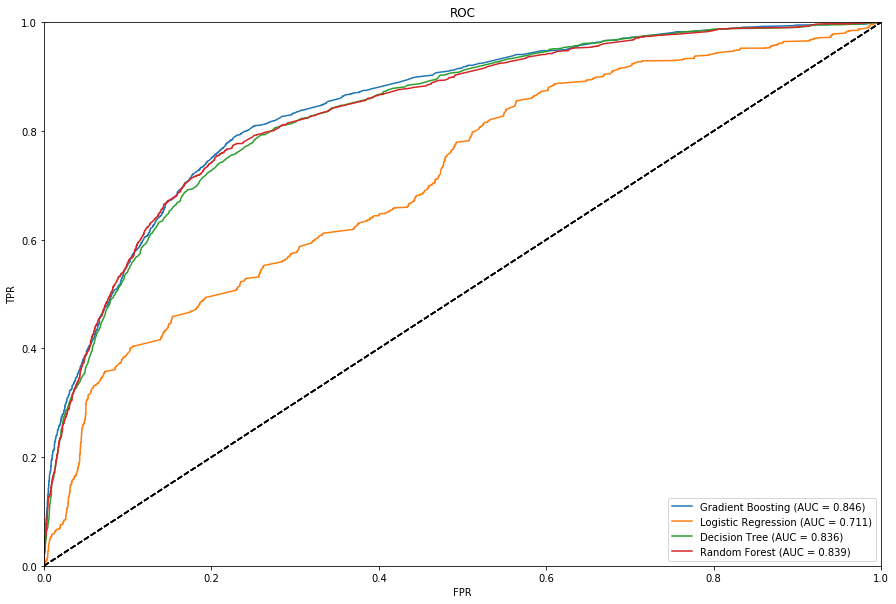

In [21]:
# Accompany with the parameters found by the other file 'Best Graphs until Thur', 
# make a roc curve for every classifier.
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.ensemble import GradientBoostingClassifier as GBC
# Firstly, run a Logistic Regression
lg_mi = linear_model.LogisticRegression(C = 1, solver = 'newton-cg')
lg_mi.fit(mi_train.drop(['result'], axis = 1), mi_train['result'])
mi_lg = lg_mi.predict_proba(mi_test.drop(['result'], axis = 1))[:, 1]
# And Decision Tree
DT_mi = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 10, min_samples_split = 100)
DT_mi.fit(mi_train.drop(['result'], axis = 1), mi_train['result'])
mi_DT = DT_mi.predict_proba(mi_test.drop(['result'], axis = 1))[:, 1]
# And Gradient Boosting
gra_boost_mi = GBC(loss = 'deviance', max_features = 'auto', min_samples_leaf = 20, 
                   min_samples_split = 100, n_estimators = 2000) 
gra_boost_mi.fit(mi_train.drop(['result'], axis = 1), mi_train['result'])
mi_gbc = gra_boost_mi.predict_proba(mi_test.drop(['result'], axis = 1))[:, 1]
# And Random Forest
RF_mi = RandomForestClassifier(max_depth = 20, max_features = None, min_samples_leaf = 3, 
                               min_samples_split = 12, n_estimators = 100, criterion = 'entropy')
# Train the model
RF_mi.fit(mi_train.drop("result", 1), mi_train['result'])
# Make predictions
mi_RF = RF_mi.predict_proba(mi_test.drop("result", 1))[:,1]

def plotROC(preds, truth, name):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    # chooses a random color for plotting
    #c = (np.random.rand(), np.random.rand(), np.random.rand())
    #create the plot
    plt.plot(fpr, tpr, label = name + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

# Plot ROC for all models
fig = plt.figure(figsize = (15, 10))
plotROC(mi_gbc, mi_test['result'], 'Gradient Boosting')
plotROC(mi_lg, mi_test['result'], 'Logistic Regression')
plotROC(mi_DT, mi_test['result'], 'Decision Tree')
plotROC(mi_RF, mi_test['result'], 'Random Forest')
plt.show()